# Interpolation Method

The method used is that of tricubic splines based on the derivation of Cheney and Kincaid(2008).The method is based on the observation that because each pair of knots is connected by a cubic, the second derivative within each interval is a straight line.This way the second derivatives can be represented by a first-order Langrange interpolating polynomial:

$$f_{i}^{''}(x) = f_{i}^{''}(x_{i-1})\frac{x-x_{i}}{x_{i-1}-x_{i}} + f_{i}^{''}(x_{i})\frac{x-x_{i-1}}{x_{i}-x_{i-1}} \tag{1}$$, where $f_{i}^{''}(x)$ is the value of the second derivative at any point x within the $i$-th interval.Thus, this equation is a straight line connecting the second derivative at the first knot $f^{''}(x_{i-1})$ with the second derivative at the second knot $f^{''}(x_{i})$.Integrating equation $(1)$ twice we get an expression for $f_{i}(x)$, containing two unknown integrating constants which can be evaluated invoking the function-equality conditions - $f(x)$ must be equal $f(x_{i-1})$ at $x_{i-1}$ and $f(x)$ must equal $f(x_{i})$ at $x_{i}$.This results to:

$$f_{i}(x) = \frac{f_{i}^{''}(x_{i-1})}{6(x_{i}-x_{i-1})}(x_{i}-x)^{3} + \frac{f_{i}^{''}(x_{i})}{6(x_{i}-x_{i-1})}(x-x_{i-1})^{3} + \left[ \frac{f(x_{i-1})}{(x_{i}-x_{i-1})} - \frac{f^{''}(x_{i-1})(x_{i}-x_{i-1})}{6} \right](x_{i}-x) + \left[ \frac{f(x_{i})}{(x_{i}-x_{i-1})} - \frac{f^{''}(x_{i})(x_{i}-x_{i-1})}{6} \right](x-x_{i-1})\tag{2}$$

The only two unknows are the second derivatives at the beginning and the end of the interval - $f^{''}(x_{i-1})$ and $f^{''}(x_{i})$.So, if we can determine the proper second derivative at each knot, equation $(2)$ is a third-order polynomial that can be used to interpolate within the interval.The second derivatives can be evaluated by invoking the condition that the first derivatives at the knots must be continuous:
$$ f_{i}^{'}(x_{i}) = f_{i+1}^{'}(x_{i}) \tag{3}$$


Differentiating equation $(2)$, we can get an expression for the first derivative.If this is done for both the $(i-1)$-th and $i$-th intervals the two results are set equal according to equation $(3)$.This yields:
$$(x_{i}-x_{i-1})f^{''}(x_{i-1}) + 2(x_{i+1}-x_{i-1})f^{''}(x_{i}) + (x_{i+1}-x_{i})f^{''}(x_{i+1}) = \frac{6}{(x_{i+1}-x_{i})}[f(x_{i+1})-f(x_{i})] + \frac{6}{(x_{i}-x_{i-1})}[f(x_{i-1})-f(x_{i})] \tag{4}$$

Writting equation $(4)$ for all knots, $n-1$ simultaneous equations result with $n+1$ unknown second derivatives.However, because this is a natural cubic spline, the second derivatives at the end knots are zero and the problem reduces to $n-1$ equations with $n-1$ unknowns.


### References
Numerical Methods for Engineers, $6$th edition, Steven C. Chapra - Raymond P. Canale.

Interpolation started...


  0%|          | 0/1 [00:00<?, ?it/s]

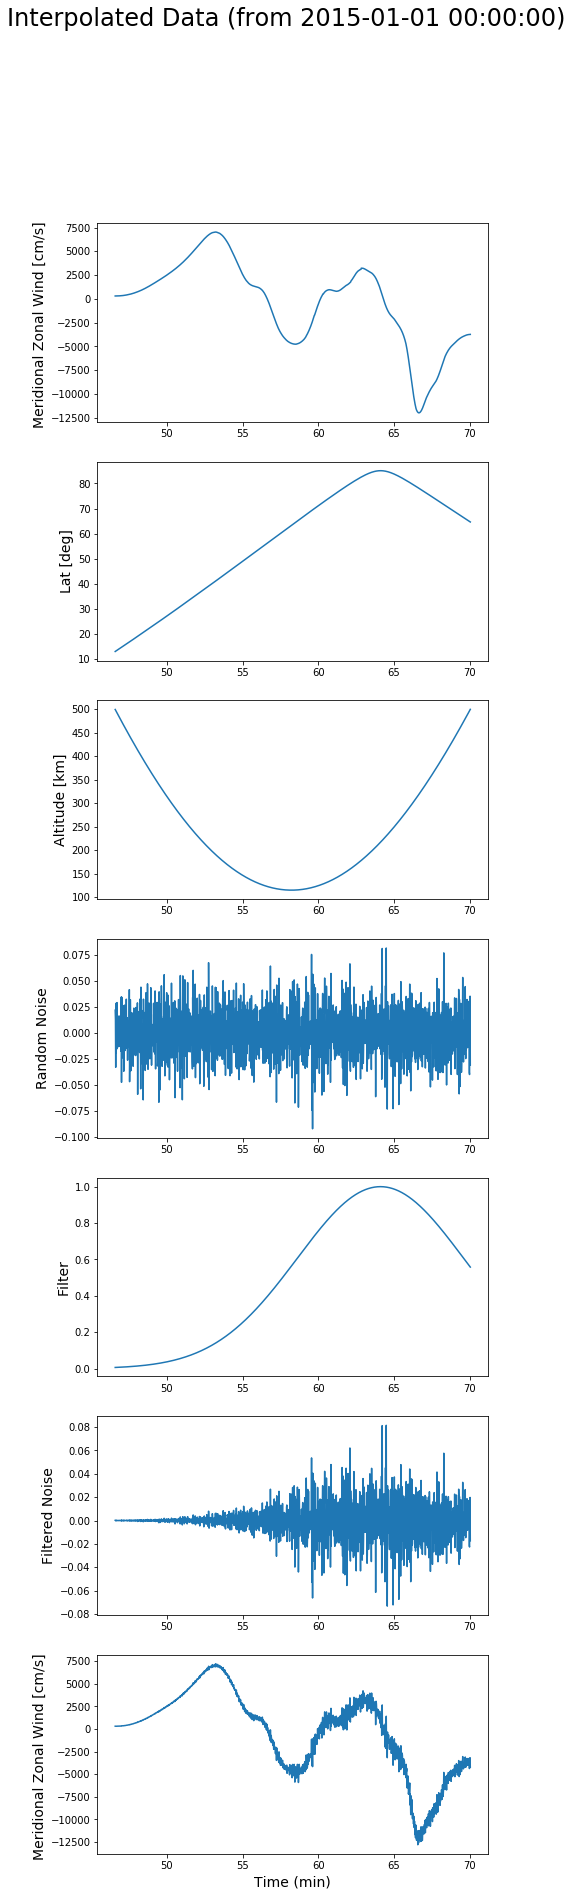

CudaSupportError: Error at driver init: 
[804] Call to cuInit results in UNKNOWN_CUDA_ERROR:

In [1]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
%matplotlib inline  
import pandas as pd
import numpy as np
import pandas as pd
from pandas import DataFrame
from datetime import datetime
import time
import os
import sys
import multiprocessing
from functools import partial
from scipy.signal import savgol_filter
import warnings

warnings.filterwarnings('ignore')

startTime = 0


class Model:
    def __init__(self,name, maxAltitude, minAltitude):
        self.name=name
        self.maxAltitude=maxAltitude
        self.minAltitude=minAltitude
        self.dt=0.0



    def readGrid(self,name):
        TIEGCM=Dataset(name+".nc")
        glat=TIEGCM.variables['lat'][:]
        glon=TIEGCM.variables['lon'][:]
        glev=TIEGCM.variables['lev'][:]
        gtime=TIEGCM.variables['time'][:] 
        zg=TIEGCM.variables['ZGMID'][:]
        TIEGCM.close()
        self.dt= gtime[2]- gtime[1]
       
        return np.asarray(gtime),np.asarray(glat),np.asarray(glon),np.asarray(glev),np.asarray(zg)

    def readVar(self,model,name):
        TIEGCM=Dataset(model+".nc")
        var   = TIEGCM.variables[name][:]
        try:
            units = TIEGCM.variables[name].units
        except:
            units = ""
        TIEGCM.close()
        return var, units


class Orbit:
    def __init__(self,name):
        self.name=name
        self.dt=1/16



    def createorbit(self,filename,minAlt,maxAlt,outfile,Save=False):
        orbit=Dataset(filename+".nc","r")
        daed_lat_temp = orbit.variables['lat'][:]
        daed_lon_temp = orbit.variables['lon'][:]
        daed_alt_temp = orbit.variables['altitude'][:]
        daed_time_temp = orbit.variables['time'][:] #unix time
        
        global startTime
        startTime = daed_time_temp[0]
        

#         self.dt=daed_time_temp[2]-daed_time_temp[1]
        self.Save=Save
        
        if self.Save==True:
            self.OpenFile(outfile,daed_time_temp,daed_lat_temp,daed_lon_temp,daed_alt_temp)
        
        stop=False
        counter=0
        for i in range(0,len(daed_alt_temp)):
            if (daed_alt_temp[i] < maxAlt and daed_alt_temp[i] > minAlt):
                counter=counter+1

        
        
        daed_lat=np.zeros((counter))
        daed_lon=np.zeros((counter))
        daed_alt=np.zeros((counter))
        daed_time=np.zeros((counter),dtype=datetime)
        index=[None]*counter
        int_final=[None]*len(daed_alt_temp)


   
        counter2=0
        
        for i in range(0,len(daed_alt_temp)):
    
            if (daed_alt_temp[i] < maxAlt and daed_alt_temp[i] > minAlt):
         
                daed_time[counter2]=daed_time_temp[i]
                daed_lat[counter2]=daed_lat_temp[i]
                if daed_lon_temp[i]>180:
                    daed_lon[counter2]=daed_lon_temp[i]-180 #match TIEGCM grid
                else:
                    daed_lon[counter2]=daed_lon_temp[i]
                daed_alt[counter2]=daed_alt_temp[i]
                
                index[counter2]=i          #keep indices for merging data
                counter2=counter2+1
        

        return(daed_time,daed_lat,daed_lon,daed_alt,index,int_final)

    def RockeOrbit(self,lat,lon,alt,nop,dz):
        Rlat=np.zeros(nop)
        Rlon=np.zeros(nop)
        Ralt=np.zeros(nop)

        Rlat[:]=lat
        Rlon[:]=lon
        Ralt[0]=alt
        for i in range(1,nop):
            Ralt[i]=Ralt[i-1]+dz

        return Rlat,Rlon,Ralt

    def mergeData(self,index,int_final,m):
        for i in range(0,len(m)):
            int_final[index[i]]=m[i]

        return int_final    



    def OpenFile(self,outfile,time,lat,lon,alt):
        print("Output File Path:",outfile)
        ncout = Dataset(outfile, "w", format="NETCDF4")    
        ncout.createDimension("time", len(time))
        xaxis=np.arange(0,len(time)) #time axis based on Daedalus Sampling rate
        data = ncout.createVariable("time","f4","time")
        data[:]=xaxis
        ncout.createDimension("lat",len(lat))
        data = ncout.createVariable("lat","f4","lat")
        data[:]=lat
        ncout.createDimension("lon",len(lon))
        data = ncout.createVariable("lon","f4","lon")
        data[:]=lon
        ncout.createDimension("altitude",len(alt))
        data = ncout.createVariable("altitude","f4","time")
        data[:]=alt
        ncout.close()   
        return True



def geod_lat2geo_lat(phi):

    # calculate geocentric latitude from geodetic latitude
    # according to WGS 84
    a = 6378137  # meter semi major axis of earth
    f = 1 / 298.257  # flattening
    b = a - f * a  # semi minor axis
    e = ((a ** 2 - b ** 2) ** (1 / 2)) / a
    phi_rad = np.deg2rad(phi)
    geo_lat = np.arctan((1 - e ** 2) * np.tan(phi_rad))
    geo_lat = np.rad2deg(geo_lat)
    return geo_lat  # in degrees



def local(dim1,y,x):
    local_pos=0
    for i in range(0,len(x)-1):
        if y >= x[i] and y < x[i+1]:
            local_pos=i
            return (local_pos)
    return (local_pos)


def cubic_spline(points, values, int_point):
    # check for length of data
    if len(points) != 4:
        raise ValueError('Number of points must be 4')

    if len(values) != 4:
        raise ValueError('Number of values must be 4')

    # check if data are sorted
    flag = 0
    for i in range(0, len(points) - 1):
        if points[i] <= points[i+1]:
            flag = 1
        else:
            flag = 0

        if flag == 0:
            raise ValueError("List not sorted")
        
    a_1 = 2 * (points[2] - points[0])
    a_2 = points[2] - points[1]
    a_3 = a_2
    a_4 = 2 * (points[3] - points[1])

    b_1 = (6 / (points[2] - points[1])) * (values[2] - values[1]) + (6 / (points[1] - points[0])) * (values[0] - values[1])
    b_2 = (6 / (points[3] - points[2])) * (values[3] - values[2]) + (6 / (points[2] - points[1])) * (values[1] - values[2])

    m_list = [[a_1, a_2], [a_3, a_4]]
    A = np.array(m_list)

    B = np.array([b_1, b_2])

    X = np.linalg.inv(A).dot(B)

    c_1 = X[0]
    c_2 = X[1]

    if points[0] <= int_point <= points[1]:
        s_1 = (c_1 / (6 * (points[1] - points[0]))) * (int_point - points[0]) ** 3 + \
              (values[0] / (points[1] - points[0])) * (points[1] - int_point) + \
              (values[1] / (points[1] - points[0]) - (c_1 * (points[1] - points[0])) / 6) * (int_point - points[0])

        return s_1
    elif points[1] <= int_point <= points[2]:
        s_2 = (c_1 / (6 * (points[2] - points[1]))) * (points[2] - int_point) ** 3 + \
              (c_2 / (6 * (points[2] - points[1]))) * (int_point - points[1]) ** 3 + \
              (values[1] / (points[2] - points[1]) - (c_1 * (points[2] - points[1])) / 6) * (points[2] - int_point) + \
              (values[2] / (points[2] - points[1]) - (c_2 * (points[2] - points[1])) / 6) * (int_point - points[1])

        return s_2
    elif points[2] <= int_point <= points[3]:
        s_3 = (c_2 / (6 * (points[3] - points[2]))) * (points[3] - int_point) ** 3 + \
              (values[2] / (points[3] - points[2]) - (c_2 * (points[3] - points[2])) / 6) * (points[3] - int_point) + \
              (values[3] / (points[3] - points[2])) * (int_point - points[2])

        return s_3


def sort(points, data):
    for i in range(0, len(points) - 1):
        for j in range(0, len(points) - i - 1):
            if points[j] > points[j+1]:
                temp_point = points[j]
                temp_data = data[j]
                points[j] = points[j+1]
                data[j] = data[j+1]
                points[j+1] = temp_point
                data[j+1] = temp_data
    return points, data
                                

def neighbors(points, int_point):
    location = 0
    for i in range(0, len(points) - 1):
        if points[i] <= int_point < points[i + 1]:
            if abs(abs(points[i]) - abs(int_point)) <= abs(abs(points[i+1]) - abs(int_point)):
                location = i
            else:
                location = i + 1       
    if location == 0:
        loc_1 = location
        loc_2 = location + 1
        loc_3 = location + 2
        loc_4 = location + 3
    elif location  == len(points) - 1:
        loc_1 = location
        loc_2 = location - 1
        loc_3 = location - 2
        loc_4 = location - 3
    elif location == len(points) - 2:
        loc_1 = location
        loc_2 = location + 1
        loc_3 = location - 1
        loc_4 = location - 2     
    elif location == 1:
        loc_1 = location
        loc_2 = location + 1
        loc_3 = location - 1
        loc_4 = location + 2
    else:
        loc_1 = location
        loc_2 = location + 1
        loc_3 = location - 1
        if abs(abs(int_point) - abs(points[location-2])) <= abs(abs(int_point) - abs(points[location+2])):
            loc_4 = location - 2
        else:
            loc_4 = location + 2

    return loc_1, loc_2, loc_3, loc_4

from tqdm import tqdm
def Interpolate(glat,glon,glev,dtime,dlat,dlon,dalt,zg,ne,Plot=False,thisLabel="TN"):
    counter=TIEGCMtiemstep_widget.value #counter=11

    m=np.zeros((len(dalt)))
        
    for i in range(0,len(dalt)):
        sorted_points_x_all = []
        sorted_points_y_all = []
        
        sorted_locx = []
        sorted_locy = []
        
        locy_1, locy_2, locy_3, locy_4 = neighbors(glat, dlat[i])
        loc_y_all = [locy_1, locy_2, locy_3, locy_4]
        points_y_all = [glat[locy_1], glat[locy_2], glat[locy_3], glat[locy_4]]
        
        sorted_y_all, sorted_locy = sort(points_y_all, loc_y_all)
        
        if dlon[i] > 177.5:
            locx_1 = len(glon) - 1
            locx_2 = len(glon) - 2
            locx_3 = len(glon) - 3
            locx_4 = 0
            points_x_all = [glon[locx_1], glon[locx_2], glon[locx_3], abs(glon[locx_4])]
            loc_x_all = [locx_1, locx_2, locx_3, locx_4]
        else:
            locx_1, locx_2, locx_3, locx_4 = neighbors(glon, dlon[i])
            loc_x_all = [locx_1, locx_2, locx_3, locx_4]
            points_x_all = [glon[locx_1], glon[locx_2], glon[locx_3], glon[locx_4]]
        
        sorted_x_all, sorted_locx = sort(points_x_all, loc_x_all)
        
       
        alts = zg[counter, :, locy_1, locx_1] / 1e5
        locz_1, locz_2, locz_3, locz_4 = neighbors(alts, dalt[i])
        locz_all = [locz_1, locz_2, locz_3, locz_4]
        points_z_all = [zg[counter, locz_1, locy_1, locx_1] / 1e5, zg[counter, locz_2, locy_1, locx_1] / 1e5, zg[counter, locz_3, locy_1, locx_1] / 1e5, zg[counter, locz_4, locy_1, locx_1] / 1e5]

        sorted_points_z_all = []
        sorted_locz = []
        
        sorted_points_z_all, sorted_locz = sort(points_z_all, locz_all)
        
        values = []
        
        values_x = np.zeros(4)
        values_y = np.zeros(4)
        
        for dz in range(0, len(points_z_all)):
            for dy in range(0, len(loc_y_all)):
                for dx in range(0, len(loc_x_all)):
                    values.append(ne[counter, sorted_locz[dz], sorted_locy[dy], sorted_locx[dx]])

               # tck = CubicSpline(sorted_x_all, values)
               # values_x[dy] = tck(dlon[i])
                values_x[dy] = cubic_spline(sorted_x_all, values, dlon[i])
                
                values.clear()
                
           # tck2 = CubicSpline(sorted_y_all, values_x)
           # values_y[dz] = tck2(dlat[i])
            values_y[dz] = cubic_spline(sorted_y_all, values_x, dlat[i])
        
       # tck3 = CubicSpline(sorted_points_z_all, values_y)
       # m[i] = tck3(dalt[i])
        m[i] = cubic_spline(sorted_points_z_all, values_y, dalt[i])
        
    return (m)



def Write(outfile,m,varname):

    ncout = Dataset(outfile, "a", format="NETCDF4")
    data = ncout.createVariable(varname,"f4",('time'))
    data[:]=m
    ncout.close()
    
    
def fftnoise(f):
    f = np.array(f, dtype='complex')
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1:Np+1] *= phases
    f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
    return np.fft.ifft(f).real

def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
    f = np.zeros(samples)
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = 1
    return fftnoise(f)


def interpolationNoise(idata, dtime, dlat, dalt, Plot=False, thisLabel="TN"):
    
    noise = band_limited_noise(0.1, 0.9, len(idata), 1)
    
    min=np.zeros((len(dtime)))
    for i in range(0,len(dtime)):
        min[i] = (dtime[i] - startTime)/1000/60
    
    #plt.plot(min, noise*400)
    
    max = np.argmax(idata)        
    peak = np.argmax(dlat)
    
    #if dlat[peak] < 55:
     #   return idata
    
    i = peak
    countLeft = 0
    while i >0:
        if dlat[i] >= 55:
            countLeft += 1
            i -= 1
        else:
            break
    
    
    i = peak
    countRight = 0
    while i < len(dlat)-1:
        if dlat[i] >= 55:
            countRight += 1
            i += 1
        else:
            break
        
    width = countLeft
    if(countRight > countLeft):
        width = countRight
    
    xpoints = np.linspace(0, len(dtime)-1, len(dtime))
    height = 1
    mean = peak
    #width = width 

    yfilter = height * np.exp( - ((xpoints-mean)/width)**2 )
    
    
    if Plot== True:
        fig = plt.figure()
        fig.set_figheight(30)
        fig.set_figwidth(7)
        
        ax1 = fig.add_subplot(711)
        ax2 = fig.add_subplot(712)
        ax3 = fig.add_subplot(713)
        ax4 = fig.add_subplot(714)
        ax5 = fig.add_subplot(715)
        ax6 = fig.add_subplot(716)
        ax7 = fig.add_subplot(717)


        ax1.plot(min,idata)
        ax2.plot(min,dlat)
        ax3.plot(min,dalt)
        ax4.plot(min,noise)
        ax5.plot(min,yfilter)
        ax6.plot(min,yfilter*noise)
        ax7.plot(min,idata+yfilter*noise*idata[max]*4)
        
        ax1.set_ylabel(thisLabel, fontsize=14)
        ax2.set_ylabel("Lat [deg]", fontsize=14)
        ax3.set_ylabel("Altitude [km]", fontsize=14)
        ax4.set_ylabel("Random Noise", fontsize=14)
        ax5.set_ylabel("Filter", fontsize=14)
        ax6.set_ylabel("Filtered Noise", fontsize=14)
        ax7.set_ylabel(thisLabel, fontsize=14)
        
        plt.suptitle('Interpolated Data (from ' + str(datetime.utcfromtimestamp(startTime/1000.0).strftime('%Y-%m-%d %H:%M:%S')) + ')', fontsize=24)
        plt.xlabel("Time (min)", fontsize=14)
        plt.show() 
    
    return idata+yfilter*noise*idata[max]*4
    
    
    
from ipywidgets import*
import ipywidgets as widgets
import warnings
import sys
sys.path.insert(1, "../SourceCode")
import DaedalusGlobals as DaedalusGlobals
import glob
import os

layout1 = {'width':'850px'}
style1 = {'description_width':'150px'}
layout2 = {'width':'200px'}
style2 = {'description_width':'120px'}
layout1_with_borders = Layout( border='solid 2px green', width='900px' )
TIEGCMtiemstep_widget = widgets.IntText( value=1, description='TIEGCM timestep:', style=style1, layout=layout1)
Noise_enable_widget   = widgets.Checkbox( value=True, description='Apply Noise')
SGV_enable_widget     = widgets.Checkbox( value=True, description='Apply Sub-Grid-Variability')
SGV_amplitude_widget  = widgets.FloatText( value=20, description=' with Amplitude: Kp *', style=style2, layout=layout2)
SGV_scale_widget      = widgets.FloatText( value=100, description=' and Max Scale:',  style=style2, layout=layout2)
SGV_cuda_widget       = widgets.Checkbox( value=True, description='Run with CUDA')


def LoadGUI():
   
    layout1 = {'width':'850px'}
    style1 = {'description_width':'150px'}
    
    tiegcm_file=widgets.Dropdown(options=sorted(glob.glob(DaedalusGlobals.TIEGCM_Files_Path +"TIEGCM_EVT1_2015_StPatricksDay_Rerun/*.nc")), description='TIE-GCM files: ', style=style1, layout=layout1)
    tiegcm_file.value = "/home/NAS/TIEGCM_DATA/TIEGCM_EVT1_2015_StPatricksDay_Rerun/tiegcm_dres.s_mar2015_amie_v1_31_Rerun.nc"
    orbit_file=widgets.Dropdown(options=sorted(glob.glob(DaedalusGlobals.Orbit_Files_Path +"DAED_ORB_Evt0_LLA*.nc")), description='Orbit files: ', style=style1, layout=layout1)
    saveOption= widgets.Checkbox(value=False,  description="Save Output",style=style1, layout=layout1)
    TGvar=widgets.Dropdown(
            options=['All','XNMBAR','TI','TN','OP','DEN','HALL','HE','PEDERSEN','POTEN','TE',
                    'O2_CM3', 'EEX', 'EEY', 'EEZ', 'ELECDEN', 'N2_CM3', 'NOP_LAM', 'NPLUS', '02P', 'O_CM3'
                    'UN', 'VN', 'WN_lev', 'HALL', 'N2D', 'N4S', 'NO', 'Ui_lev', 'Vi_lev', 'WI_LEV'],
            value='EEX',
            description='TIEGCM Variable:',
            disabled=False,
            style=style1, 
            layout=layout1
            )
    def Exec_Btn_Clicked( b ):
        
        print( "Interpolation started..." )
        
        if TGvar.value=='All':
            thisLabel="TN"
            tgvars=['All','XNMBAR','TI','TN','OP','DEN','HALL','HE','PEDERSEN','POTEN','TE',
                    'O2_CM3', 'EEX', 'EEY', 'EEZ', 'ELECDEN', 'N2_CM3', 'NOP_LAM', 'NPLUS', '02P', 'O_CM3'
                    'UN', 'VN', 'WN_lev', 'HALL', 'N2D', 'N4S', 'NO', 'Ui_lev', 'Vi_lev', 'WI_LEV']
            RunInterpolator(os.path.splitext(tiegcm_file.value)[0],os.path.splitext(orbit_file.value)[0],tgvars,saveOption.value,thisLabel)
        else:
            thisLabel="TN"
            tgvars=[TGvar.value]
            if (TGvar.value=="XNMBAR"):
                thisLabel="Conversion Factor "
            if (TGvar.value=="TI"):
                thisLabel="Ion Temperature [K] "
            if (TGvar.value=="TN"):
                thisLabel="Neutral Temperature [K] "
            if (TGvar.value=="OP"):
                thisLabel="O+ ion [cm^-3] "
            if (TGvar.value=="DEN"):
                thisLabel="Total Density [g/cm3] "
            if (TGvar.value=="HALL"):
                thisLabel="Hall conductivity [S/m] "                
            if (TGvar.value=="HE"):
                thisLabel="Helium [mmr] " 
            if (TGvar.value=="PEDERSEN"):
                thisLabel="Pendersen condcutivity [S/m] "                 
            if (TGvar.value=="POTEN"):
                thisLabel="Electric Potential [Volts] "   
            if (TGvar.value=="TE"):
                thisLabel="Electorn Temperature [K] "     
            if (TGvar.value=="O2_CM3"):
                thisLabel="Molecular Oxygen [cm^-3] "    
            if (TGvar.value=="O2_CM3"):
                thisLabel="Molecular Oxygen [cm^-3] "                           
            if (TGvar.value=="EEX"):
                thisLabel="Electric Field East"
            if (TGvar.value=="EEY"):
                thisLabel="Electric Field North"
            if (TGvar.value=="EEZ"):
                thisLabel="Electric Field Up"
            if (TGvar.value=="ELECDEN"):
                thisLabel="Electron Density [cm^-3] "
            if (TGvar.value=="N2_CM3"):
                thisLabel="Molecular Nitrogen [cm^-3] "
            if (TGvar.value=="NOP_LAM"):
                thisLabel="NO+ Ion [cm^-3] "
            if (TGvar.value=="NPLUS"):
                thisLabel="N+ Ion [cm^-3] "
            if (TGvar.value=="02P"):
                thisLabel="O2+ Ion  [cm^-3] "
            if (TGvar.value=="O_CM3"):
                thisLabel="Atomic Oxygen  [cm^-3] "
            if (TGvar.value=="UN"):
                thisLabel="Neutral Zonal Wind  [cm/s] "
            if (TGvar.value=="VN"):
                thisLabel="Meridional Zonal Wind [cm/s] "
            if (TGvar.value=="WN_lev"):
                thisLabel="Vertical Zonal Wind [cm/s] "
            if (TGvar.value=="HALL"):
                thisLabel="Hall conductivity [S/m] "
            if (TGvar.value=="N2D"):
                thisLabel="N2D [mmr] "
            if (TGvar.value=="N4S"):
                thisLabel="N4S [mmr] "
            if (TGvar.value=="NO"):
                thisLabel="Nitric Oxide [mmr] "
            if (TGvar.value=="Ui_lev"):
                thisLabel="Zonal ExB velocity [cm/s] "
            if (TGvar.value=="Vi_lev"):
                thisLabel="Meridional ExB velocity [cm/s] "
            if (TGvar.value=="WI_LEV"):
                thisLabel="Vertical ExB velocity [cm/s] "
                
                
            RunInterpolator(os.path.splitext(tiegcm_file.value)[0],os.path.splitext(orbit_file.value)[0],tgvars,saveOption.value,thisLabel)
  

    def createGUI():
        MainPanel = widgets.VBox() 
        MainTab = widgets.Tab() 
        VerticalPanel = widgets.VBox()
        MapPanel = widgets.VBox()
        MainTab.children = [ VerticalPanel ]
        MainTab.set_title(0, 'Interpolator')
        MainPanel.children = [MainTab ]   
        Exec_Btn = widgets.Button (description='Run',tooltip="Click here to Interpolate",)
        Exec_Btn.style.button_color = 'Red'
        Exec_Btn.on_click( Exec_Btn_Clicked )
        NOISEpanel = widgets.HBox( [Noise_enable_widget], style=style1, layout=layout1_with_borders )
        SGVpanel = widgets.HBox( [SGV_enable_widget, SGV_amplitude_widget, SGV_scale_widget, SGV_cuda_widget], style=style1, layout=layout1_with_borders )
        VerticalPanel.children = [tiegcm_file, TIEGCMtiemstep_widget, orbit_file, TGvar, saveOption, NOISEpanel, SGVpanel, Exec_Btn]
    
        return MainPanel
    display( createGUI() )


def RunInterpolator(model_data_file,orbit_file,TGvar,Save=False,thisLabel="TN"):
    model=Model(model_data_file ,500,100)  #initialize model
    orbit=Orbit(orbit_file)                #initialize  orbit
    outfile=os.getenv("HOME")+"/"+os.path.basename(model_data_file)+"_Interpolated.nc"
    dtime,dlat,dlon,dalt,index,int_final=orbit.createorbit(orbit.name,model.minAltitude,model.maxAltitude,outfile,Save)
    gtime,glat,glon,glev,zg=model.readGrid(model.name)                                     #get model stats
    

    kp = model.readVar(model.name,"Kp")
    
    
    #select variable
    for jj in tqdm(range(len(TGvar))):
        var, units = model.readVar(model.name,TGvar[jj])
        interpolatedData1      = Interpolate(glat,glon,glev,dtime, dlat,dlon,dalt,zg,var,True,thisLabel)
        # convert units if necessary
        if units == "V/cm":
            units = "mV/m"
            interpolatedData1 *= 100000
        # apply noise to data if user says so
        if Noise_enable_widget.value == True:
            interpolationNoiseData = interpolationNoise(interpolatedData1, dtime, dlat, dalt, True, thisLabel)
        else:
            interpolationNoiseData = interpolatedData1
        # apply Sub-Grid-Variability to data if user says so
        if SGV_enable_widget.value == True:
            DataPlusVariability    = ApplySGV( interpolationNoiseData, dlat, dlon, dalt, thisLabel, units, SGV_amplitude_widget.value * kp[0][TIEGCMtiemstep_widget.value], SGV_scale_widget.value, SGV_cuda_widget.value) 
        else:
            DataPlusVariability    = interpolationNoiseData
        # bundle
        interpolatedData = orbit.mergeData(index,int_final,DataPlusVariability)
        # save
        if Save == True: 
            Write(outfile,interpolatedData,TGvar[jj])
            
        
import sys
sys.path.insert(1, './SubGridVariability/')
import SGV_Gaussians_VGA as SGV

import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import chart_studio.plotly as py 


def ApplySGV( Data, Latitudes, Longitudes, Altitudes, variableName, Units, MaxAmplitude, MaxScale, UseCUDA ):
    Data_plus_SGV = [0.0] * len(Data)
    myRange = range(0, len(Data)) 
    for i in myRange:
        Data_plus_SGV[i] = Data[i] + SGV.calculateSGV_forSinglePoint( Latitudes[i], Longitudes[i],  MaxAmplitude, MaxScale, UseCUDA )
    # display the Sub-Grid-Variability spikes
    SGV.SGVpreview_forWorld( UseCUDA )
    # calculate min & max of data
    Data_Min = min( Data )    
    if min(Data_plus_SGV) < Data_Min: Data_Min = min(Data_plus_SGV)
    Data_Max = max( Data )
    if max(Data_plus_SGV) > Data_Max: Data_Max = max(Data_plus_SGV)
    Data_Min -= abs(Data_Min) * 0.15
    Data_Max += abs(Data_Max) * 0.15
    # PLOT Variable-vs-Time
    color1 = "#3a5199"
    color2 = "#506d2f"
    color3 = "#e1b80d"
    color4 = "red"
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(myRange), y=Data,          name=variableName,                            marker=dict(color=color4, size=1), visible="legendonly" ) )
    fig.add_trace(go.Scatter(x=list(myRange), y=Latitudes,     name="Latitude",                  yaxis="y2", marker=dict(color=color2, size=2) ) ) 
    fig.add_trace(go.Scatter(x=list(myRange), y=Altitudes,     name="Altitude",                  yaxis="y3", marker=dict(color=color3, size=2) ) ) 
    fig.add_trace(go.Scatter(x=list(myRange), y=Data_plus_SGV, name=variableName+"+Variability", yaxis="y4", marker=dict(color=color1, size=3) ) )
    fig.update_layout(
        title = "Sub-Grid-Variability for " + variableName + " (" + Units + ")",
        xaxis = dict( domain=[0.0, 0.84],  title="time" ),
        yaxis  = dict( title="",                          titlefont=dict(color=color4), range=[Data_Min, Data_Max],  anchor="free", visible=False),
        yaxis2 = dict( title="Latitude",                  titlefont=dict(color=color2), tickfont=dict(color=color2), anchor="free", overlaying="y", side="right", position=0.85 ),
        yaxis3 = dict( title="Altitude",                  titlefont=dict(color=color3), tickfont=dict(color=color3), anchor="free", overlaying="y", side="right", position=0.95 ),
        yaxis4 = dict( title=variableName+"+Variability", titlefont=dict(color=color1), range=[Data_Min, Data_Max], overlaying="y", tickfont=dict(color=color1)),
    )
    plotly.offline.init_notebook_mode(connected=True)
    plotly.offline.iplot(fig) 
    # PLOT Variable-vs-Latitude
    # straighten x axis
    LatitudesStraight = [0.0] * len(Latitudes)
    for i in range(0, len(Latitudes)):
        if  i==0 or Latitudes[ i ] > Latitudes[ i - 1 ]:
            LatitudesStraight[ i ] = Latitudes[ i ]
        else:
            LatitudesStraight[ i ] = max(Latitudes) + max(Latitudes) - Latitudes[ i ]
    # correct tick values
    mytickvals = list()
    myticktext = list()
    mytickvals.append( int(max(Latitudes)) )
    myticktext.append( "{:02.2f}".format(max(Latitudes)) )
    for i in range( int(min(LatitudesStraight)), int(max(LatitudesStraight)) ):
        if i % 10 == 0:
            mytickvals.append( i )
            if i < 90:
                myticktext.append( i )
            else:
                myticktext.append( "{:02.0f}".format(int(max(Latitudes)-(i-max(Latitudes)))) )
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=LatitudesStraight, y=Data,          name=variableName,                            marker=dict(color=color4, size=1), visible="legendonly" ) )
    fig.add_trace(go.Scatter(x=LatitudesStraight, y=Altitudes,     name="Altitude",                  yaxis="y2", marker=dict(color=color3, size=2) ) ) 
    fig.add_trace(go.Scatter(x=LatitudesStraight, y=Data_plus_SGV, name=variableName+"+Variability", yaxis="y3", marker=dict(color=color1, size=3) ) )
    fig.update_layout(
        title = "Sub-Grid-Variability for " + variableName + " (" + Units + ")",
        xaxis = dict( domain=[0.0, 0.84],  title="Latitude", tickvals=mytickvals, ticktext=myticktext ),
        yaxis  = dict( title="",                          titlefont=dict(color=color4), range=[Data_Min, Data_Max],  anchor="free", visible=False),
        yaxis2 = dict( title="Altitude",                  titlefont=dict(color=color3), tickfont=dict(color=color3), anchor="free", overlaying="y", side="right", position=0.95 ),
        yaxis3 = dict( title=variableName+"+Variability", titlefont=dict(color=color1), range=[Data_Min, Data_Max], overlaying="y", tickfont=dict(color=color1)),
    )
    plotly.offline.init_notebook_mode(connected=True)
    plotly.offline.iplot(fig) 
    return Data_plus_SGV


LoadGUI()



